### 0. Introduction - Contexte & Objectifs Métier

Ce projet vise à construire un Employee Risk Score pour le secteur RH/Assurance.
Objectif : anticiper l'attrition, l'absentéisme et la baisse de performance.
Livrable : modèle ML + insights + recommandations métier.

In [3]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu, ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import shap
import joblib

### 2. Compréhension des données (Data Understanding)

In [5]:
df = pd.read_csv("data/employee_risk_attrition_dirty.csv")
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   employee_id         1000 non-null   int64  
 1   age                 1000 non-null   int64  
 2   tenure_years        1000 non-null   int64  
 3   job_role            1000 non-null   object 
 4   performance_score   1000 non-null   float64
 5   training_hours      975 non-null    float64
 6   satisfaction_level  972 non-null    float64
 7   salary              971 non-null    float64
 8   work_life_balance   1000 non-null   float64
 9   absenteeism_days    1000 non-null   int64  
 10  manager_rating      974 non-null    float64
 11  overtime_hours      1000 non-null   int64  
 12  promotion_last_2y   1000 non-null   int64  
 13  attrition           1000 non-null   int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 109.5+ KB


,employee_id,age,tenure_years,performance_score,training_hours,satisfaction_level,salary,work_life_balance,absenteeism_days,manager_rating,overtime_hours,promotion_last_2y,attrition
count,1000.000000,1000.000000,1000.00000,1000.000000,975.000000,972.000000,971.000000,1000.000000,1000.000000,974.000000,1000.00000,1000.000000,1000.000000
mean,500.500000,41.612000,9.43800,2.930439,25.465363,0.597665,4988.257467,3.049124,18.642000,3.010673,34.32900,0.147000,0.214000
std,288.819436,11.546808,5.82461,0.802882,9.863128,0.192724,1781.172565,0.960397,17.518068,0.949100,21.97598,0.354283,0.410332
min,1.000000,22.000000,0.00000,1.000000,0.000000,0.074971,1805.000000,1.000000,-3.000000,1.000000,-2.00000,0.000000,0.000000
25%,250.750000,31.000000,4.00000,2.391198,18.610539,0.460686,3460.500000,2.371815,7.000000,2.390357,16.00000,0.000000,0.000000
50%,500.500000,42.000000,9.00000,2.974732,25.189912,0.594238,4929.000000,3.062018,17.000000,2.954254,34.00000,0.000000,0.000000
75%,750.250000,52.000000,15.00000,3.467606,32.492897,0.722303,6465.500000,3.715811,28.000000,3.670380,52.00000,0.000000,0.000000
max,1000.000000,61.000000,19.00000,5.000000,55.885122,1.000000,8199.000000,5.000000,195.000000,5.000000,145.00000,1.000000,1.000000


Variables numériques : age, tenure_years, performance_score, training_hours, salary, absenteeism_days, overtime_hours, manager_rating, attrition.
Variable catégorielle : job_role

In [7]:
df.sample(5)

,employee_id,age,tenure_years,job_role,performance_score,training_hours,satisfaction_level,salary,work_life_balance,absenteeism_days,manager_rating,overtime_hours,promotion_last_2y,attrition
981,982,50,12,Expert Sinistres,3.456939,25.465132,0.168350,3557.0,2.042847,29,1.518670,36,0,0
786,787,23,3,Conseiller Client,1.734266,16.561900,0.643069,2312.0,1.000000,26,3.764804,69,0,1
315,316,48,5,Expert Sinistres,3.237533,51.347408,0.412736,3510.0,3.239159,4,4.785128,43,0,0
722,723,55,13,Expert Sinistres,1.510012,17.879458,0.316598,NaN,3.317595,-3,3.909062,56,1,0
893,894,61,14,Analyste RH,3.158045,16.942818,0.307094,5203.0,2.229321,-1,2.516769,48,1,0


### 3. Valeurs manquantes (Missing Values)

In [9]:
missing = df.isna().mean()
print(missing)

employee_id           0.000
age                   0.000
tenure_years          0.000
job_role              0.000
performance_score     0.000
training_hours        0.025
satisfaction_level    0.028
salary                0.029
work_life_balance     0.000
absenteeism_days      0.000
manager_rating        0.026
overtime_hours        0.000
promotion_last_2y     0.000
attrition             0.000
dtype: float64


Proportions des donnees manquantes:
2,5% de training_hours, 
2,8% de satisfaction_level, 
2,9% de salary, 
2,6% de manager_rating

In [11]:
#Creation des flags---on joue sur les valeurs vides--Gardez la traçabilité
for col in ['satisfaction_level','training_hours','manager_rating','salary']:
    df[f'flag_missing_{col}'] = df[col].isna().astype(int)

### 4. Détection des anomalies
Certaines valeurs extrêmes ou incohérentes (ex. jours d'absence négatifs, score de performance > 5)
peuvent perturber l'analyse et les modèles.  
Une détection des anomalies est donc réalisée afin de garantir la qualité et la cohérence du dataset.

In [13]:
cols = ['absenteeism_days','overtime_hours','performance_score','satisfaction_level']

# Forcer une conversion
for col in cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Vérification directe des lignes problématiques
print(df[cols].isna().sum())

# Correction business logic
df.loc[df['absenteeism_days'] < 0, 'absenteeism_days'] = 0
df.loc[df['overtime_hours'] < 0, 'overtime_hours'] = 0

df['performance_score'] = df['performance_score'].clip(1, 5)
df['satisfaction_level'] = df['satisfaction_level'].clip(0, 1)

df[cols].describe()


absenteeism_days       0
overtime_hours         0
performance_score      0
satisfaction_level    28
dtype: int64


,absenteeism_days,overtime_hours,performance_score,satisfaction_level
count,1000.000000,1000.000000,1000.000000,972.000000
mean,18.797000,34.370000,2.930439,0.597665
std,17.340949,21.910115,0.802882,0.192724
min,0.000000,0.000000,1.000000,0.074971
25%,7.000000,16.000000,2.391198,0.460686
50%,17.000000,34.000000,2.974732,0.594238
75%,28.000000,52.000000,3.467606,0.722303
max,195.000000,145.000000,5.000000,1.000000


Nous constatons 28 donnees de satisfaction_level manquantes.

In [15]:
df['satisfaction_level'] = df['satisfaction_level'].fillna(df['satisfaction_level'].median())

Les valeurs manquantes de satisfaction_level ont été conservées comme un signal potentiel. Un indicateur binaire a été créé pour identifier les employés non évalués, puis une imputation par la médiane a été appliquée afin de préserver la stabilité statistique pour la modélisation.

In [17]:
# ==========================================
# Sauvegarde du dataset nettoyé
# ==========================================

df.to_csv("data/employee_risk_clean.csv", index=False)
print("✅ Dataset nettoyé sauvegardé : data/employee_risk_clean.csv")


✅ Dataset nettoyé sauvegardé : data/employee_risk_clean.csv


### 5. Analyses exploratoires (EDA)

In [19]:
# Charger le dataset nettoyé
df = pd.read_csv("data/employee_risk_clean.csv")

# Vérification rapide
print(df.shape)
df.head()


(1000, 18)


,employee_id,age,tenure_years,job_role,performance_score,training_hours,satisfaction_level,salary,work_life_balance,absenteeism_days,manager_rating,overtime_hours,promotion_last_2y,attrition,flag_missing_satisfaction_level,flag_missing_training_hours,flag_missing_manager_rating,flag_missing_salary
0,1,25,16,Analyste RH,3.770368,12.405869,0.620364,5406.0,2.838771,1,3.640894,8,0,0,0,0,0,0
1,2,52,14,Expert Sinistres,2.420311,11.868323,0.317472,6027.0,4.889380,7,1.000000,2,0,1,0,0,0,0
2,3,48,11,Commercial,2.316993,23.453892,0.336994,8086.0,4.385060,33,NaN,26,0,0,0,0,1,0
3,4,39,17,Commercial,3.367765,13.111198,0.323767,6632.0,3.354479,11,2.951014,21,0,1,0,0,0,0
4,5,39,2,Back Office,3.790843,17.972450,0.698291,3155.0,2.974706,0,4.486039,54,0,0,0,0,0,0


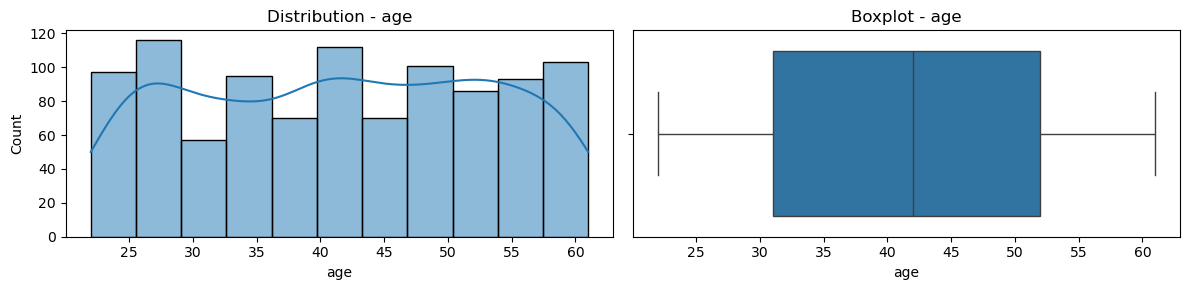

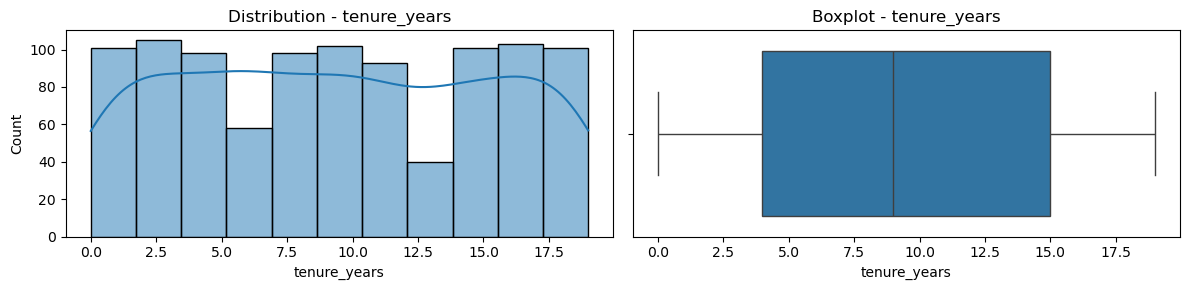

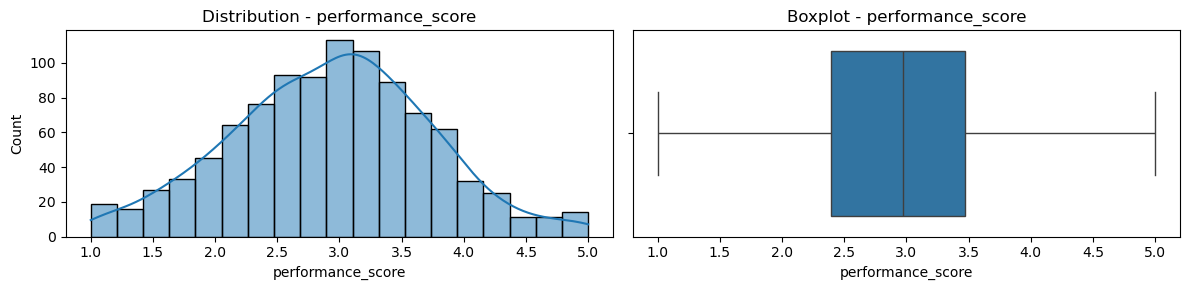

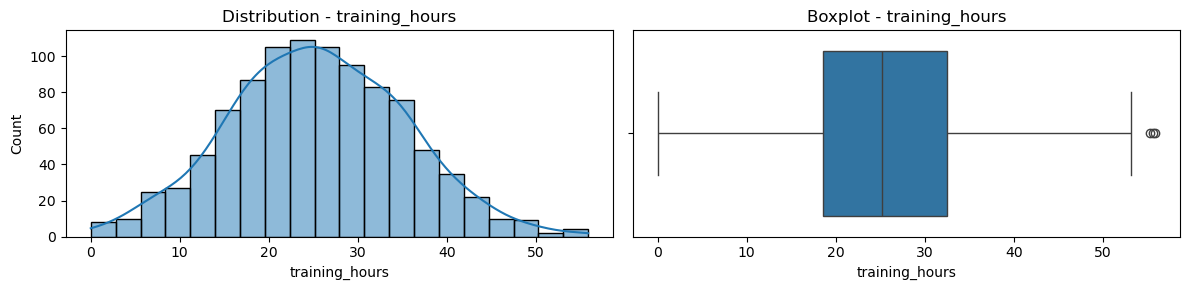

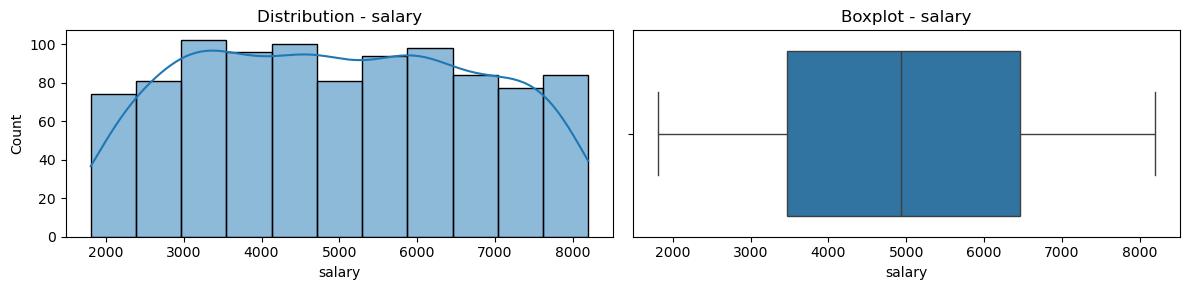

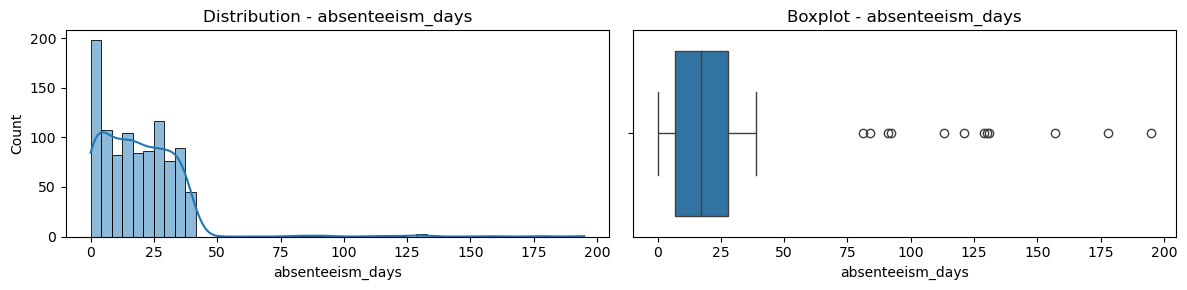

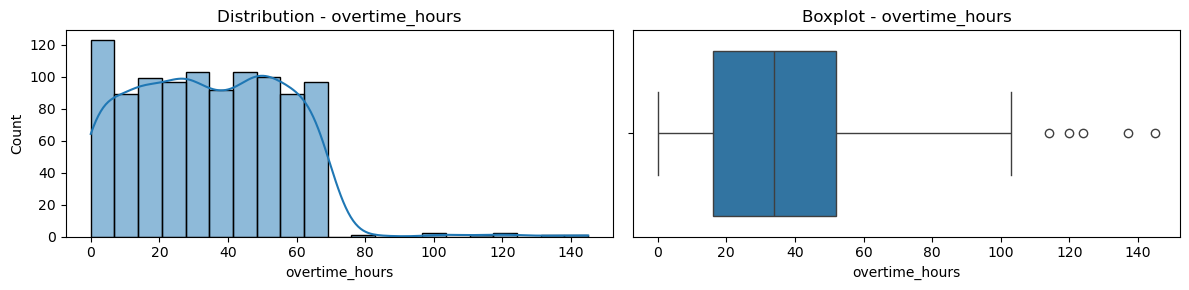

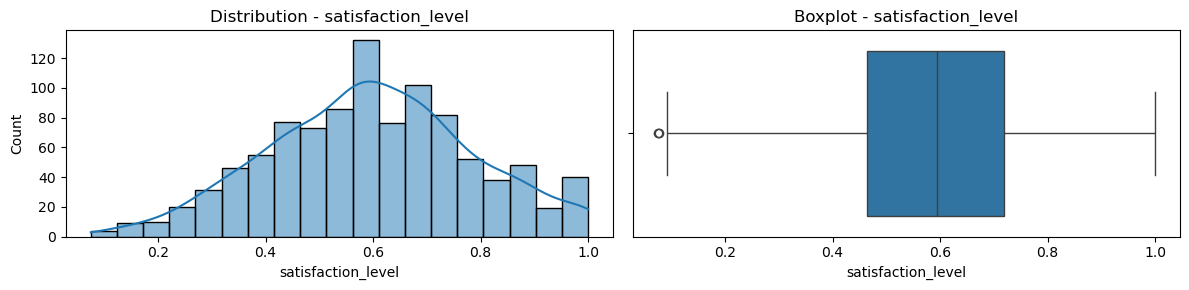

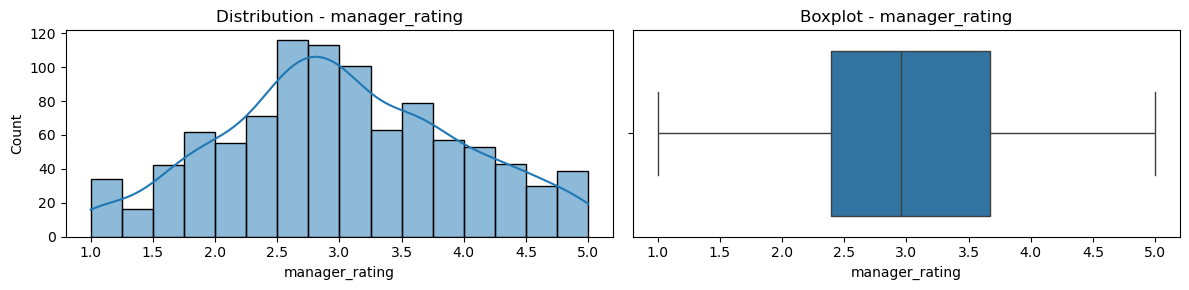

In [20]:
# 5.1 Univariée : distributions et boxplots
num_cols = ['age','tenure_years','performance_score','training_hours','salary',
            'absenteeism_days','overtime_hours','satisfaction_level','manager_rating']
for col in num_cols:
    fig, axes = plt.subplots(1,2, figsize=(12,3))
    sns.histplot(df[col].dropna(), ax=axes[0], kde=True)
    axes[0].set_title(f'Distribution - {col}')
    sns.boxplot(x=df[col], ax=axes[1])
    axes[1].set_title(f'Boxplot - {col}')
    plt.tight_layout()
    plt.show()

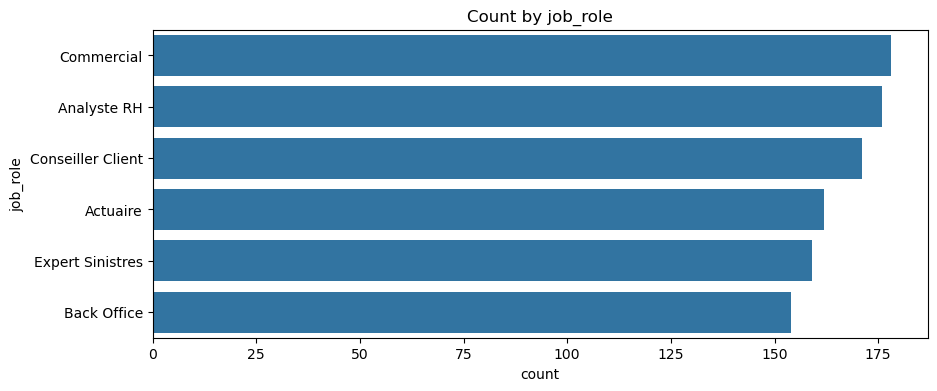

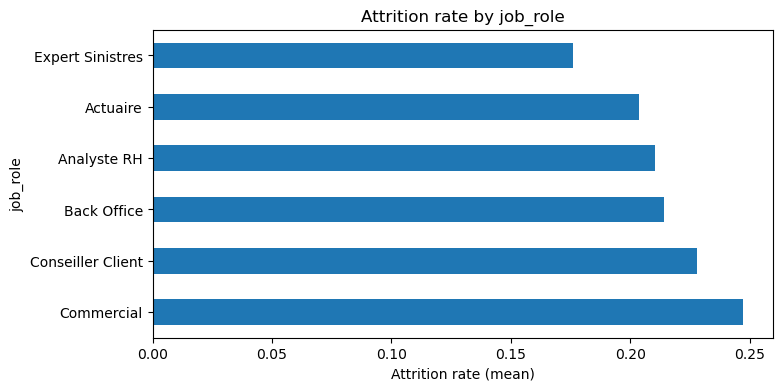

job_role
Commercial           0.247191
Conseiller Client    0.228070
Back Office          0.214286
Analyste RH          0.210227
Actuaire             0.203704
Expert Sinistres     0.176101
Name: attrition, dtype: float64

In [21]:
# job_role counts
plt.figure(figsize=(10,4))
sns.countplot(y='job_role', data=df, order=df['job_role'].value_counts().index)
plt.title('Count by job_role')
plt.show()

# Attrition rate per job_role
role_attr = df.groupby('job_role')['attrition'].mean().sort_values(ascending=False)
plt.figure(figsize=(8,4))
role_attr.plot(kind='barh')
plt.xlabel('Attrition rate (mean)')
plt.title('Attrition rate by job_role')
plt.show()

display(role_attr)

Le taux d'attrition moyen est élevé du service commercial vers l'expert sinistres

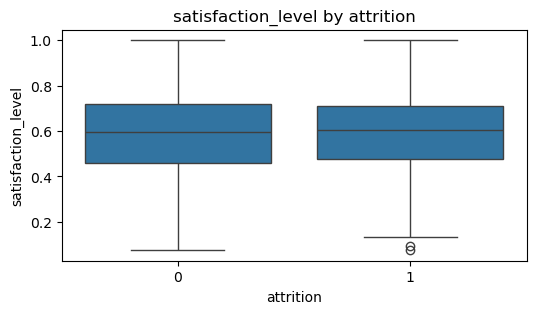

attrition
0    0.595066
1    0.606763
Name: satisfaction_level, dtype: float64
----------------------------------------


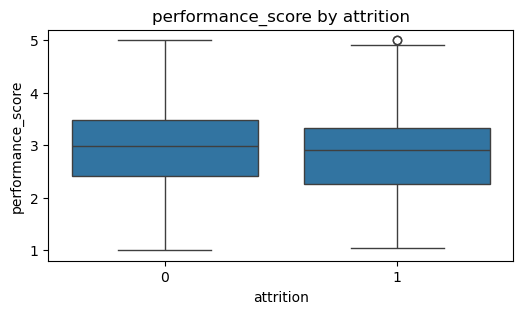

attrition
0    2.950840
1    2.855506
Name: performance_score, dtype: float64
----------------------------------------


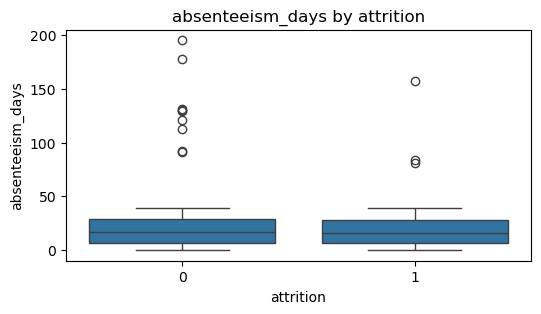

attrition
0    18.862595
1    18.556075
Name: absenteeism_days, dtype: float64
----------------------------------------


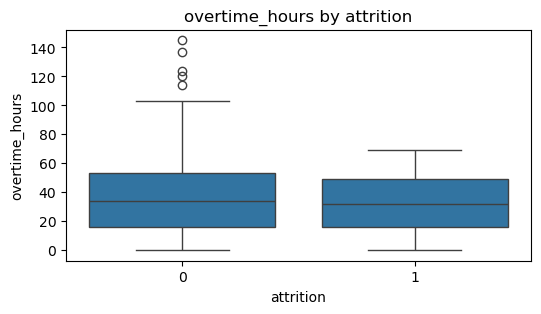

attrition
0    34.562341
1    33.663551
Name: overtime_hours, dtype: float64
----------------------------------------


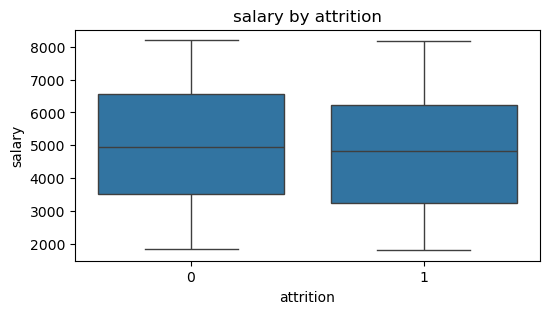

attrition
0    5035.233987
1    4813.805825
Name: salary, dtype: float64
----------------------------------------


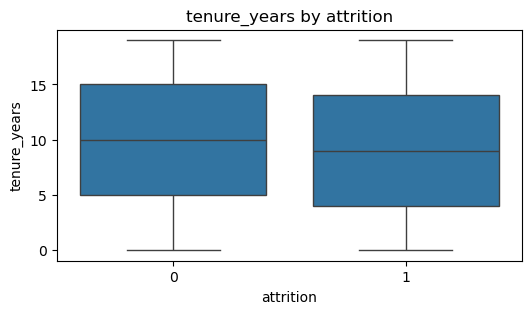

attrition
0    9.595420
1    8.859813
Name: tenure_years, dtype: float64
----------------------------------------


In [23]:
# 5.2 Bivariée : distributions et boxplots
# comparer distributions numériques selon attrition (0 vs 1)
cols_to_compare = ['satisfaction_level','performance_score','absenteeism_days','overtime_hours','salary','tenure_years']

for col in cols_to_compare:
    plt.figure(figsize=(6,3))
    sns.boxplot(x='attrition', y=col, data=df)
    plt.title(f'{col} by attrition')
    plt.show()

    # afficher moyennes
    print(df.groupby('attrition')[col].mean())
    print('-'*40)


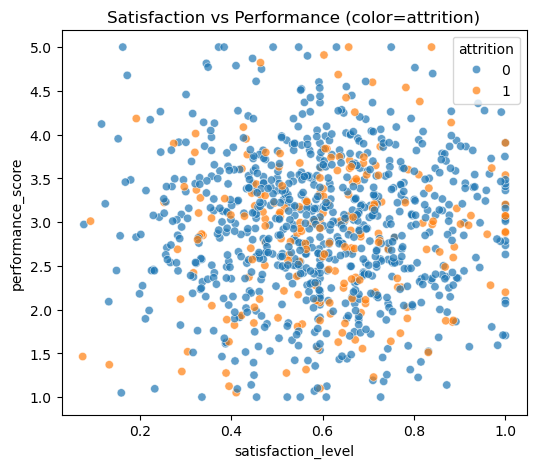

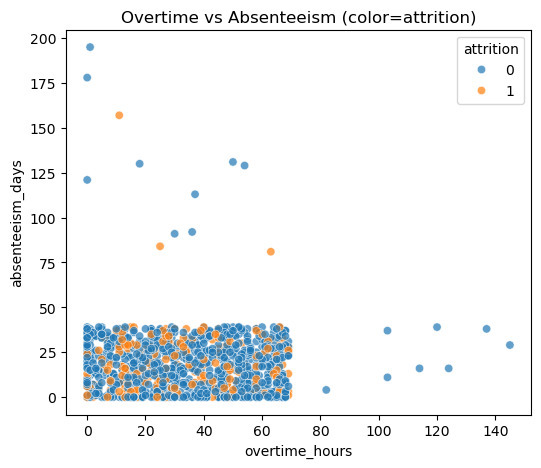

In [24]:
# satisfaction vs performance colored by attrition
plt.figure(figsize=(6,5))
sns.scatterplot(x='satisfaction_level', y='performance_score', hue='attrition', data=df, alpha=0.7)
plt.title('Satisfaction vs Performance (color=attrition)')
plt.show()

# absenteeism vs overtime
plt.figure(figsize=(6,5))
sns.scatterplot(x='overtime_hours', y='absenteeism_days', hue='attrition', data=df, alpha=0.7)
plt.title('Overtime vs Absenteeism (color=attrition)')
plt.show()


### Scatter plot Overtime vs Absenteeism

Observation :  
La majorité des employés sont concentrés dans le nuage principal (peu d’heures supplémentaires, peu d’absences).  
Quelques individus se détachent avec à la fois beaucoup d’heures supplémentaires ou beaucoup d’absences.

Interprétation :  
Ces profils extrêmes montrent un risque de désengagement ou de départ.  
La coloration par attrition montre que certains de ces employés ont effectivement quitté l’entreprise.

Action recommandée :  
Mettre en place un suivi ciblé pour ces employés (charge de travail, coaching, équilibre vie pro/vie perso).


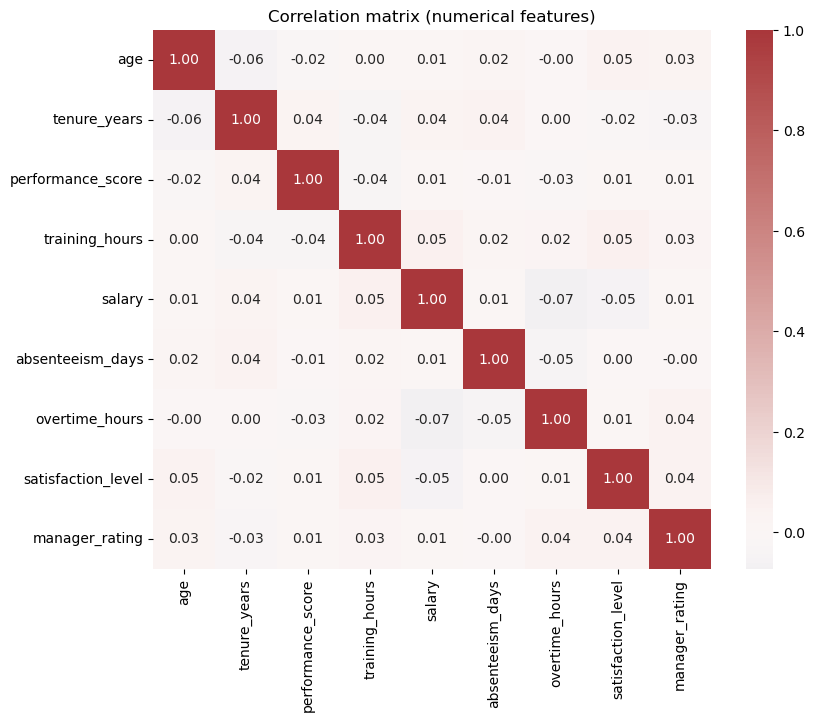

,mean_not_attrit,mean_attrit,diff
training_hours,25.310369,26.040412,0.730044
satisfaction_level,0.595066,0.606763,0.011696
manager_rating,3.025004,2.957570,-0.067434
performance_score,2.950840,2.855506,-0.095334
absenteeism_days,18.862595,18.556075,-0.306521
tenure_years,9.595420,8.859813,-0.735607
overtime_hours,34.562341,33.663551,-0.898790
age,41.825700,40.827103,-0.998597
salary,5035.233987,4813.805825,-221.428162


In [26]:
# matrice de corrélation
num_for_corr = ['age','tenure_years','performance_score','training_hours','salary','absenteeism_days','overtime_hours','satisfaction_level','manager_rating']
plt.figure(figsize=(9,7))
sns.heatmap(df[num_for_corr].corr(), annot=True, fmt=".2f", cmap='vlag', center=0)
plt.title('Correlation matrix (numerical features)')
plt.show()

# Tableau synthétique : moyenne des features par attrition
summary = df.groupby('attrition')[num_for_corr].mean().T
summary.columns = ['mean_not_attrit','mean_attrit']
summary['diff'] = summary['mean_attrit'] - summary['mean_not_attrit']
summary.sort_values('diff', ascending=False, inplace=True)
display(summary)



### 6. Feature Engineering

In [28]:
#Différence significative ou pas ?
tests = {}
for col in num_for_corr:
    group0 = df[df['attrition']==0][col].dropna()
    group1 = df[df['attrition']==1][col].dropna()
    # On choisit Mann-Whitney (non-paramétrique) pour robustesse
    stat, p = mannwhitneyu(group0, group1, alternative='two-sided')
    tests[col] = p

pd.Series(tests).sort_values()


tenure_years          0.100464
performance_score     0.114098
salary                0.118928
manager_rating        0.195144
age                   0.250155
training_hours        0.379438
satisfaction_level    0.418868
overtime_hours        0.746534
absenteeism_days      0.925606
dtype: float64

### Interpretation des resultats du test de Mann-Whitney
En ce qui concerne les variables (tenure_years, perfomance_score, salary, manager_rating, age, training_hours, satisfaction_level), les deux groupe (attrit et non_attrit) sont significativement differentes
tandis que pour les variables (absenteeism_days et overtime_hours), il n'existe pas de difference significative entre les deux differents groupes.

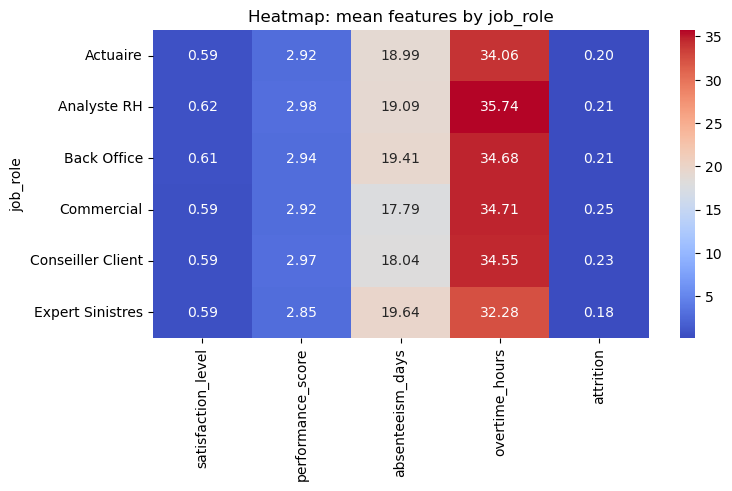

In [30]:
# Heatmap des moyennes features par job_role
role_summary = df.groupby('job_role')[['satisfaction_level','performance_score','absenteeism_days','overtime_hours','attrition']].mean()
plt.figure(figsize=(8,4))
sns.heatmap(role_summary, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Heatmap: mean features by job_role')
plt.show()


Certains rôles (Analystes RH) présentent plus d’heures supplémentaires, (les experts Sinistres )un absentéisme plus élevé et une satisfaction plus faible, ce qui signale un risque accru d’attrition et de désengagement.
Il est donc necessaire de prioriser ces postes pour des mesures RH ciblées (formation, suivi, ajustement de la charge de travail).

In [32]:
missing = df.isna().mean()
print(missing)

employee_id                        0.000
age                                0.000
tenure_years                       0.000
job_role                           0.000
performance_score                  0.000
training_hours                     0.025
satisfaction_level                 0.000
salary                             0.029
work_life_balance                  0.000
absenteeism_days                   0.000
manager_rating                     0.026
overtime_hours                     0.000
promotion_last_2y                  0.000
attrition                          0.000
flag_missing_satisfaction_level    0.000
flag_missing_training_hours        0.000
flag_missing_manager_rating        0.000
flag_missing_salary                0.000
dtype: float64


Salary et training_hours présentent des valeurs manquantes respectivement de 2.9% et de 2.5%.

In [34]:
# Imputation pour training_hours et salary
df['training_hours'] = df['training_hours'].fillna(df['training_hours'].median())
df['manager_rating'] = df['manager_rating'].fillna(df['manager_rating'].median())

# Imputer le salaire manquant par la médiane du job_role
df['salary'] = df.groupby('job_role')['salary'].transform(
    lambda x: x.fillna(x.median())
)

# Si certains restent NaN (job rare), on utilise la médiane globale
df['salary'] = df['salary'].fillna(df['salary'].median())

# Imputation de satisfaction par la médiane du job_role
df['satisfaction_level'] = df.groupby('job_role')['satisfaction_level'].transform(
    lambda x: x.fillna(x.median())
)

# Si des NaN subsistent (cas rares), on utilise la médiane globale
df['satisfaction_level'] = df['satisfaction_level'].fillna(df['satisfaction_level'].median())

# --- Ratios comportementaux ---
df['overtime_ratio'] = df['overtime_hours'] / (df['tenure_years'] + 1)
df['absence_ratio'] = df['absenteeism_days'] / (df['tenure_years'] +1)
df['salary_performance'] = df['salary'] / (df['performance_score'] +1)

# Score composite
df['engagement_score'] = (
    0.4 * df['satisfaction_level'] +
    0.3 * (df['training_hours'] / df['training_hours'].max()) +
    0.3 * df['manager_rating']
)

#Indicateur de surmenage
df['burnout_risk'] = ((df['overtime_ratio'] > 2) & (df['satisfaction_level'] < 0.4)).astype(int)

#Stabilité professionnelle
df['stability_score'] = df['tenure_years'] / (df['age'] + 1)

J’ai choisi de créer des variables dérivées car les valeurs brutes ne reflètent pas la réalité humaine.
J’ai donc normalisé ces données par l’ancienneté afin de modéliser des comportements relatifs comme la fatigue, l’implication ou la stabilité professionnelle.
Chaque formule repose sur une logique métier inspirée du management RH réel et de la psychologie du travail.

In [36]:
burnout_stats = (
    df.groupby('job_role')
      .agg(total_employees=('burnout_risk', 'count'),
           nb_burnout=('burnout_risk', 'sum'))
)

burnout_stats['pct_burnout'] = burnout_stats['nb_burnout'] / burnout_stats['total_employees'] * 100

print(burnout_stats)


                   total_employees  nb_burnout  pct_burnout
job_role                                                   
Actuaire                       162          21    12.962963
Analyste RH                    176          14     7.954545
Back Office                    154          22    14.285714
Commercial                     178          22    12.359551
Conseiller Client              171          17     9.941520
Expert Sinistres               159          16    10.062893


### 7. Préparation des données pour le Machine Learning

In [38]:
missing = df.isna().mean()
print(missing)

employee_id                        0.0
age                                0.0
tenure_years                       0.0
job_role                           0.0
performance_score                  0.0
training_hours                     0.0
satisfaction_level                 0.0
salary                             0.0
work_life_balance                  0.0
absenteeism_days                   0.0
manager_rating                     0.0
overtime_hours                     0.0
promotion_last_2y                  0.0
attrition                          0.0
flag_missing_satisfaction_level    0.0
flag_missing_training_hours        0.0
flag_missing_manager_rating        0.0
flag_missing_salary                0.0
overtime_ratio                     0.0
absence_ratio                      0.0
salary_performance                 0.0
engagement_score                   0.0
burnout_risk                       0.0
stability_score                    0.0
dtype: float64


In [39]:
#Séparer la cible des variables explicatives
X = df.drop(columns=['attrition', 'employee_id'])
y = df['attrition']

#job_role_encoded
le = LabelEncoder()
X['job_role'] = le.fit_transform(X['job_role'])

In [40]:
#Train Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y  #stratify garantit une répartition équilibrée (dans Train et Test) de la repartition des donnees dans 2 categories (0 vs 1)
)

### 8. Entraînement du modèle de prédiction de l’attrition

Objectif ici, du moins celui du projet est de onstruire un modèle capable de prédire :
Est-ce qu’un employé va quitter l’entreprise ou rester ?

C’est un problème de classification binaire :
0 = Non Attrition
1 = Attrition

In [43]:
#Scaling de nos donnees (variables explicatives d'entrainement et de test)
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Premier Modéle : Regression Logistique

In [45]:
#Création et entrainement du modéle
model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000)

In [46]:
#Prediction des données sur des nouvelles variables
y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:, 1]  # probabilité pour la classe 1 (Attrition)


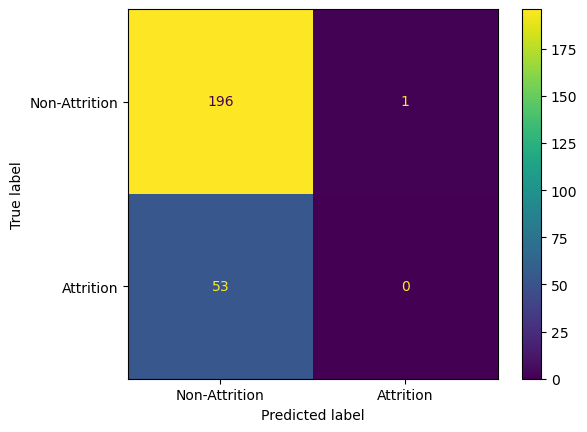

In [47]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=['Non-Attrition', 'Attrition']).plot()


### Conclusion_RégressionLogistique
Les résultats obtenus montrent que ce modèle présente des limites importantes dans la détection des employés en situation d’attrition. Sa performance ne permet pas d’identifier de manière fiable les profils à risque, ce qui suggère qu’il n’est pas adapté à cet objectif dans sa configuration actuelle. Des ajustements méthodologiques (sélection de variables, optimisation des hyperparamètres, ou recours à un autre algorithme) seraient nécessaires pour améliorer sa capacité prédictive.

In [49]:
#Tableau avec plusieurs métriques pour évaluer un modèle de classification
print(classification_report(y_test, y_pred, target_names=['Non-Attrition', 'Attrition']))


               precision    recall  f1-score   support

Non-Attrition       0.79      0.99      0.88       197
    Attrition       0.00      0.00      0.00        53

     accuracy                           0.78       250
    macro avg       0.39      0.50      0.44       250
 weighted avg       0.62      0.78      0.69       250



### Remarques :
La précision pour la classe Non-Attrition est de 0,79, ce qui signifie que 79 % des employés prédits comme n’étant pas en attrition sont réellement dans cette classe. De plus, le modèle n’a identifié aucun employé réellement en attrition.

Le rappel (sensibilité) de 0,00 confirme cette incapacité à détecter les cas d’attrition. En revanche, le modèle parvient à reconnaître correctement 99 % des employés en Non-Attrition, ce qui explique une accuracy globale de 78 %.

In [51]:
auc = roc_auc_score(y_test, y_proba)
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


NameError: name 'roc_curve' is not defined

In [ ]:
#Enregistrement de ce modèle
joblib.dump(model, "models/rg_model.pkl")

### Conclusion
Même si l’accuracy = 0.78, ce modèle ne fait pas mieux que le hasard avec AUC=0.45.
La ROC/AUC est particulièrement utile vue le déséquilibre des classes.

### Deuxième Modéle : RandomForest

In [ ]:
# Création du modèle avec class_weight pour gérer le déséquilibre
rf_model = RandomForestClassifier(
    n_estimators=200, #construit 200 arbres de décision
    max_depth=7, #limité à une profondeur de 7
    random_state=42,
    class_weight='balanced'  # Sensibilise le modèle à la classe minoritaire
)

# Entraînement
rf_model.fit(X_train_scaled, y_train)


In [ ]:
y_pred_rf = rf_model.predict(X_test_scaled) #Détermine la classe
y_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1] #Détermine la probabilité


In [ ]:
cm_rf = confusion_matrix(y_test, y_pred_rf)
ConfusionMatrixDisplay(cm_rf, display_labels=['Non-Attrition','Attrition']).plot()


In [ ]:
print(classification_report(y_test, y_pred_rf, target_names=['Non-Attrition', 'Attrition']))

Recall Attrition = 0.15 → RandomForest détecte 15% des employés à risque contrairement à RegressionLogistique qui ne détectait rien.
F1-score Attrition = 0.21 → meilleur équilibre précision/recall que Logistic Regression mais peut etre améliorer.

On peut donc conclure que Random Forest capture mieux les départs, mais il y a encore une marge pour améliorer le recall.

In [ ]:
#Importance de chaque features
importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
importances.sort_values(ascending=False).plot(kind='bar', figsize=(10,6))
plt.title("Feature Importance - Random Forest")
plt.show()


### Feature Importances :

satisfaction_level, overtime_hours, tenure_years → leviers RH prioritaires

salary, training_hours → impact secondaire

In [ ]:
#Enregistrement de ce modèle
joblib.dump(rf_model, "models/rf_model.pkl")

In [ ]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.1,
    scale_pos_weight= len(y_train[y_train==0]) / len(y_train[y_train==1]),
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb_model.fit(X_train_scaled, y_train)

y_pred_xgb = xgb_model.predict(X_test_scaled)
y_proba_xgb = xgb_model.predict_proba(X_test_scaled)[:,1]


In [ ]:
print(classification_report(y_test, y_pred_xgb, target_names=['Non-Attrition','Attrition']))

cm_xgb = confusion_matrix(y_test, y_pred_xgb)
ConfusionMatrixDisplay(cm_xgb, display_labels=['Non-Attrition','Attrition']).plot()


On constate une augmentation de 4% de la détection des employés à risque par rapport aux modéles précedents.

Nous devons aussi remarquer que le modéle détecte de mois en mois les employés non à risque.

In [ ]:
importances = pd.Series(xgb_model.feature_importances_, index=X_train.columns)
importances.sort_values(ascending=False).plot(kind='bar', figsize=(10,6))
plt.title("Feature Importance - XGBoost")
plt.show()


In [ ]:
#Enregistrement de ce modèle
joblib.dump(xgb_model, "models/best_model_xgb.pkl")

## Comparaison des modèles ML

Nous avons entraîné trois modèles pour prédire l'attrition des employés :  
1. **Logistic Regression** – baseline simple, facile à expliquer mais faible performance sur la classe minoritaire.  
2. **Random Forest** – capture mieux les départs et interactions, permet d’identifier les leviers RH.  
3. **XGBoost** – modèle boosté, légèrement plus performant sur le recall, robuste aux non-linéarités.

L’objectif est de choisir le modèle le plus fiable pour générer notre **Employee Risk Score**, avec un focus particulier sur la détection des départs (Recall Attrition) et la précision globale (F1-score).


**Choix du modèle final :** XGBoost, car il maximise la détection des employés à risque et fournit des insights actionnables pour les RH.

| Modèle                  | Accuracy | Recall Attrition | F1-score Attrition | Points forts / commentaires |
|--------------------------|---------|-----------------|------------------|-----------------------------|
| Logistic Regression      | 0.78    | 0.00            | 0.00             | Baseline simple, interprétable, mais ne détecte pas les départs |
| Random Forest            | 0.76    | 0.15            | 0.21             | Capture légèrement les départs, feature importances utiles pour recommandations RH |
| XGBoost                  | 0.72    | 0.19            | 0.22             | Meilleur recall que Logistic Regression, mais attention au surapprentissage et au tuning |


In [ ]:
# Les différenets métrique de ce projet accuracy_score, f1_score, confusion_matrix, roc_auc_score
# Liste des modèles
models = {
    'Random Forest': rf_model,
    'XGBoost': xgb_model,
    'Logistic Regression': model
}

for name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else None
    
    print(f"--- {name} ---")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    if y_proba is not None:
        print("ROC-AUC:", roc_auc_score(y_test, y_proba))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\n")


In [ ]:
scores = { 'Random Forest': f1_score(y_test, rf_model.predict(X_test_scaled)),
           'XGBoost': f1_score(y_test, xgb_model.predict(X_test_scaled)),
           'Logistic Regression': f1_score(y_test, model.predict(X_test_scaled)) }

plt.bar(scores.keys(), scores.values(), color=['skyblue', 'salmon', 'lightgreen'])
plt.title("Comparaison F1-score sur les données de test")
plt.ylabel("F1-score")
plt.show()


###  Conclusion

J’ai testé trois modèles classiques. Bien que la régression logistique ait la meilleure accuracy, elle ignore totalement la classe minoritaire. XGBoost, lui, équilibre mieux la détection des cas rares, ce qui est critique pour la performance opérationnelle.

### Entrainement du modéle sur des données de tests.

In [ ]:
# Prédictions sur les données de test
y_pred = xgb_model.predict(X_test_scaled)
y_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]  # Probabilité d'attrition

print("Classification Report :\n")
print(classification_report(y_test, y_pred))

print("ROC AUC Score :", roc_auc_score(y_test, y_proba))

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred ),
            annot=True, fmt='d', cmap='Blues')
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion - Test set")
plt.show()


In [ ]:
importances = xgb_model.feature_importances_
features = X.columns

importance_df = pd.DataFrame({
    'feature': features,
    'importance': importances
}).sort_values(by='importance', ascending=False)

importance_df.head(10)


In [ ]:
explainer = shap.Explainer(xgb_model, X_train_scaled)
shap_values = explainer(X_test_scaled)

# Graphique global
shap.summary_plot(shap_values, X_test_scaled)


In [ ]:
shap.plots.waterfall(shap_values[0])

In [ ]:
risk_proba = xgb_model.predict_proba(X_test_scaled)[:,1]

df_risk = pd.DataFrame({
    "Risk_Score": risk_proba
})

def classify_risk(x):
    if x < 0.3:
        return "Faible"
    elif x < 0.6:
        return "Moyen"
    else:
        return "Élevé"

df_risk["Risk_Level"] = df_risk["Risk_Score"].apply(classify_risk)
df_risk.head()


### Actions RH recommandées

Risque élevé :

    Entretien individuel prioritaire

    Réajustement charge de travail

    Plan de motivation

Risque moyen :

    Suivi RH trimestriel

    Coaching soft skills

Risque faible :

    Fidélisation & reconnaissance

### Visualisation finale des données


In [ ]:
plt.figure(figsize=(8,5))
plt.hist(df_risk["Risk_Score"], bins=20)
plt.title("Distribution des Employee Risk Scores")
plt.xlabel("Risk Score")
plt.ylabel("Nombre d'employés")
plt.show()


In [ ]:
top_risk = df_risk.sort_values("Risk_Score", ascending=False).head(15)
top_risk


In [ ]:
plt.figure(figsize=(10,5))
plt.bar(range(len(top_risk)), top_risk["Risk_Score"])
plt.xticks(range(len(top_risk)), top_risk.index, rotation=45)
plt.title("Top 15 employés à risque d’attrition")
plt.ylabel("Risk Score")
plt.show()


In [ ]:
plt.figure(figsize=(8,5))
sns.scatterplot(x=df["satisfaction_level"], y=df_risk["Risk_Score"], hue=df['attrition'])
plt.title("Lien Satisfaction vs Risk Score")
plt.xlabel("Satisfaction")
plt.ylabel("Risk Score")
plt.show()


### Comments ameliorer les resultats

1.Gérer le déséquilibre des classes

    Utiliser SMOTE ou oversampling pour créer plus d’exemples de la classe minoritaire.
    
    Ajuster class_weight ou scale_pos_weight pour que le modèle “pèse plus” les faux négatifs.

2.Optimiser les hyperparamètres

    Faire du GridSearchCV ou RandomizedSearchCV sur XGBoost : profondeur des arbres, learning rate, nombre d’arbres, régularisation.
    
    Cela peut améliorer la détection de la classe minoritaire sans trop sacrifier la classe majoritaire.

3.Ingénierie des features

    Ajouter des variables pertinentes ou transformer les existantes (ex. ratios, interactions).
    
    Certaines variables peuvent aider le modèle à mieux séparer les classes difficiles.

4.Evaluation adaptée

    Ne pas se fier à l’accuracy.
    
    Mettre en avant F1-score, ROC-AUC, précision/rappel pour la classe minoritaire.